## SEIRS data - 1 cycle, 2 cycle, and delta vs ngalenka region 

ngalenka is just south of podor where they did irrigation work

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates


sns.set_theme()

In [2]:
def seirs_timeseries_plot(df, pal, title=None):
    """
    Plot the timeseries of the SEIRS model derived datasets.

    In this case df is a GeoDataFrame with 4 non date column at the beginning and one geometry column at the end.
    Other layouts will mean code will break or the plot will be wrong.
    
    Parameters
    ----------
    df : GeoDataFrame
        The GeoDataFrame to plot
    pal : str
        The palette to use for the plot
    """
    fig, ax = plt.subplots(figsize=(20,5))
    sns.lineplot(df.iloc[:, 4:-1].T, palette=pal)

    labels = [label.get_text() for label in ax.get_xticklabels()]
    labels = [label.replace("_","-") for label in labels]
    labels = pd.to_datetime(labels)
    labels = labels.strftime("%Y-%d")
    # Convert the xtick labels from strings to datetime objects
    #labels = [mdates.datestr2num(label) for label in labels]

    ax.set_xticks(ax.get_xticks()[::5], labels[::5])

    # Rotate the xtick labels by 30 degrees
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xlabel('Date (YYYY-MM-DD)')
    plt.ylabel('NDVI')
    plt.title(title)
    plt.show()

Read in the data. One file for the treatment area (west/delta), one file for the control area (east/podor).

In [3]:
tzo = pd.read_pickle('treatment_zone_observed.pkl') #treatment zone observed - tzo
czo = pd.read_pickle('control_zone_observed.pkl') #control zone observed - czo

Define our sites, split up by site type (according to the MCC/Mathematica report)

Hot and Rain are sites that produce a single crop in a year, during either the hot or rainy seasons.

Both are sites that do at least a double crop cycle in a year.

Ngalenka are three sites that were irrigate in the Podor region. We might need to compare these to podor sites that had no intervention, which I have not selected yet.

In [4]:
# define our site classes and ids
delta_hot_ix = [640686, 494877, 750802]
delta_rain_ix = [542439, 625750, 479986]
delta_both_ix = [599039, 652544, 658545]
ngalenka_ix = [257258, 263217, 263214]

Cross reference site IDs with the observed datasets:

In [5]:
delta_hot = tzo[tzo['id'].isin(delta_hot_ix)]
delta_rain = tzo[tzo['id'].isin(delta_rain_ix)]
delta_both = tzo[tzo['id'].isin(delta_both_ix)]
ngalenka = czo[czo['id'].isin(ngalenka_ix)]

Map:

In [6]:
map = folium.Map(location=[16.3, -16], zoom_start=9)

colors = ['yellow', 'blue', 'green', 'orange']

for i,j in enumerate([delta_hot, delta_rain, delta_both, ngalenka]):
    for _,r in j.iterrows():
        folium.CircleMarker(location=[r['geometry'].y, r['geometry'].x], radius=5, 
                            color=colors[i], fill=True, tooltip=int(r['id']), 
                            popup=f"Lon: {r['lon']:.3f}<br>Lat: {r['lat']:.3f}"
                            ).add_to(map)

fig = folium.Figure(figsize=(16,9))
fig.add_child(map)

In [7]:
tzf = pd.read_pickle('treatment_zone_forecast.pkl') #treatment zone observed - tzo
czf = pd.read_pickle('control_zone_forecast.pkl') #control zone observed - czo

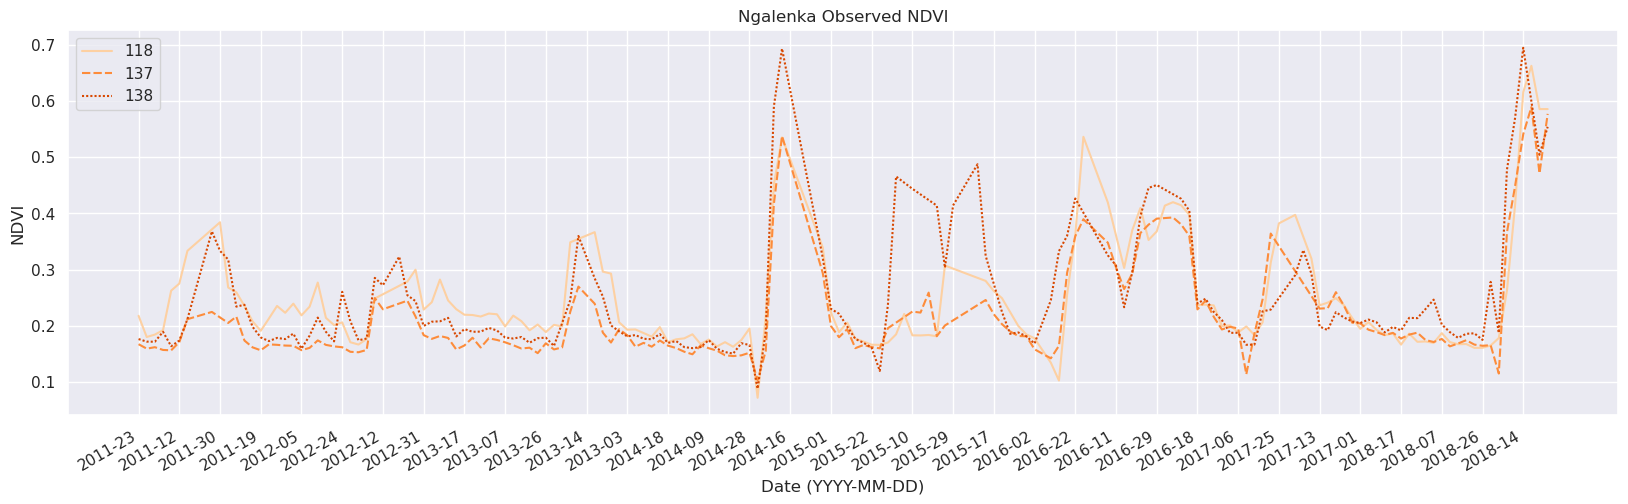

In [8]:
seirs_timeseries_plot(ngalenka, 'Oranges', title='Ngalenka Observed NDVI')

In [9]:
ngalenka_forecast = czf[czf['id'].isin(ngalenka_ix)]

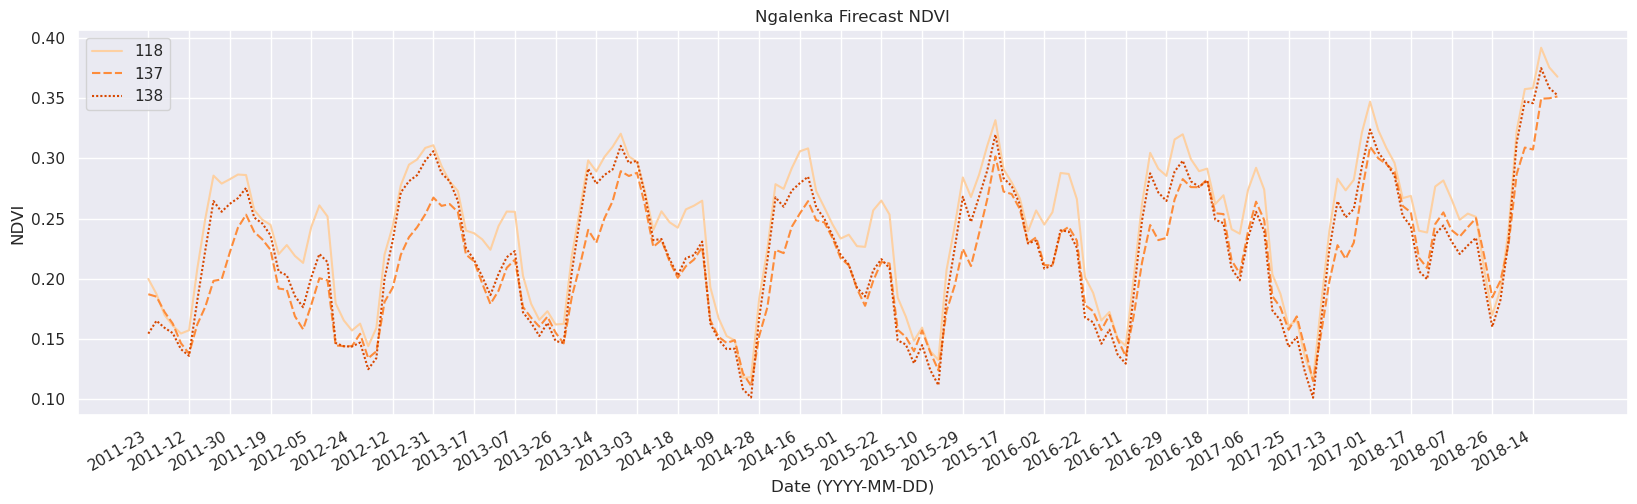

In [10]:
seirs_timeseries_plot(ngalenka_forecast, 'Oranges', title='Ngalenka Firecast NDVI')

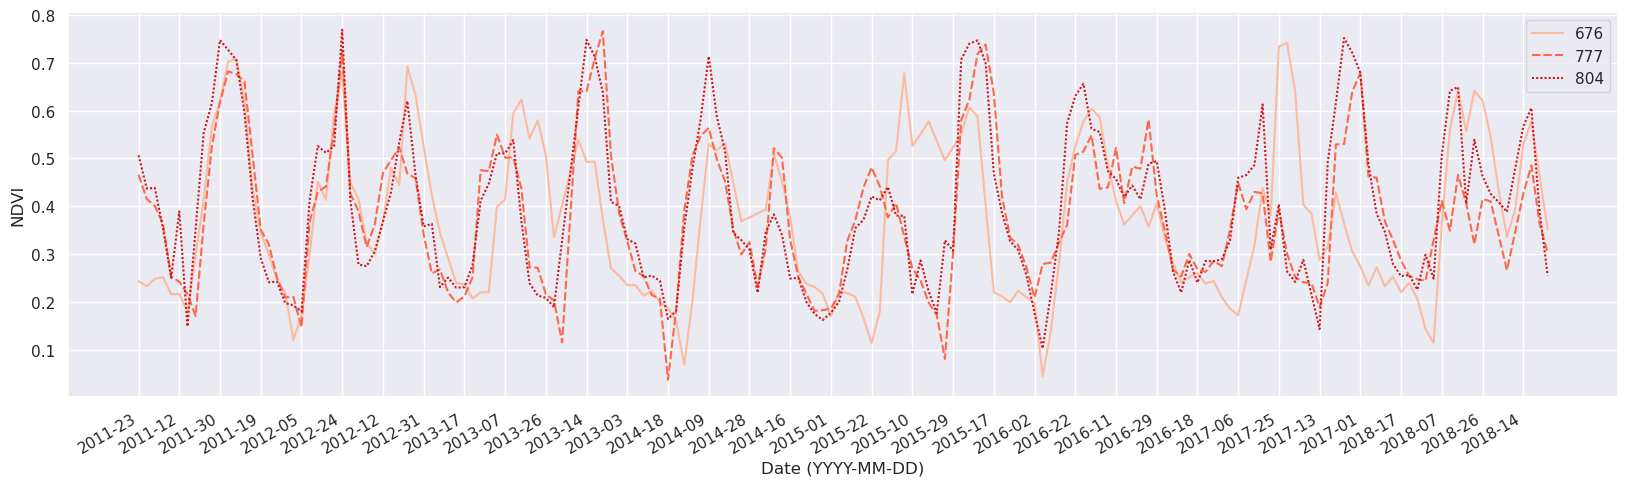

In [11]:
seirs_timeseries_plot(tzo[tzo['id'].isin(delta_hot_ix)], 'Reds')

In [12]:
ngalenka_diff = pd.concat([ngalenka[['id', 'lon', 'lat', 'cluster']], ngalenka.iloc[:,4:-1]-ngalenka_forecast.iloc[:,4:-1], ngalenka['id']], axis=1)

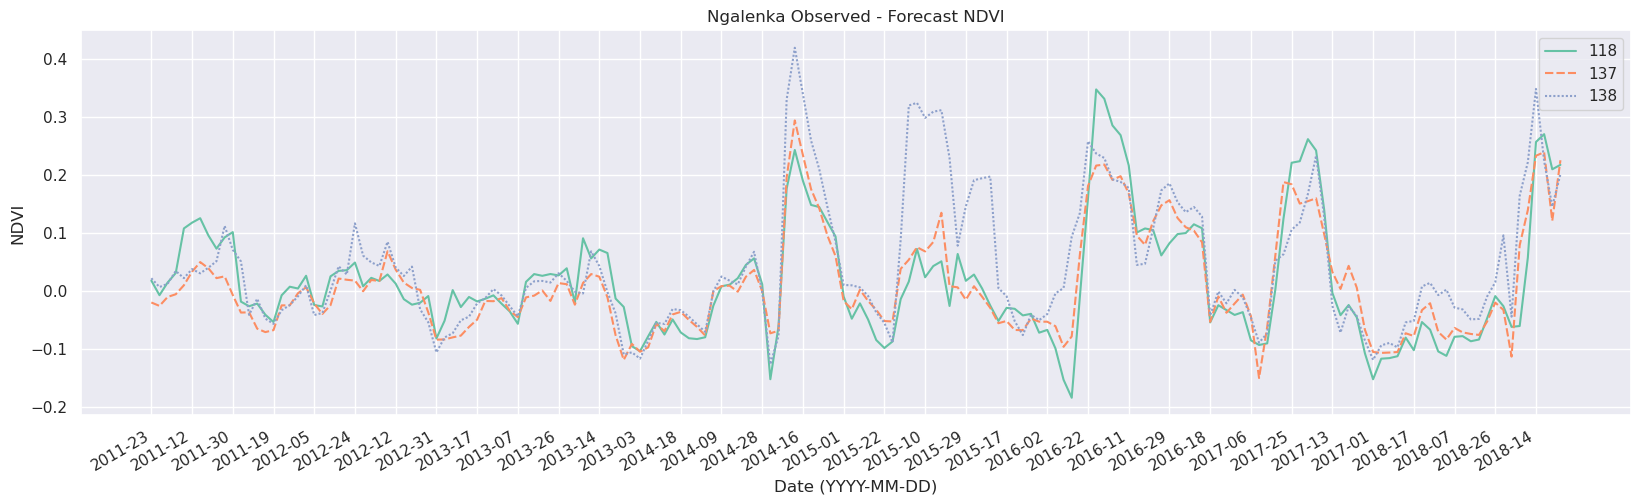

In [13]:
seirs_timeseries_plot(ngalenka_diff, 'Set2', title='Ngalenka Observed - Forecast NDVI')

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF

In [15]:
ecdf_diff = [ECDF(x) for x in ngalenka_diff.iloc[:,4:-1].values]

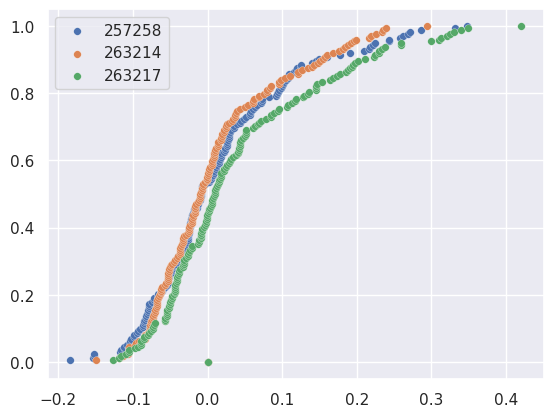

In [16]:
for ix,i in enumerate(ecdf_diff):
    i.x[np.isinf(i.x)] = 0
    plt.scatter(i.x, i.y, s=30, ec='w', lw=0.2, label=int(ngalenka['id'].iloc[ix]))
plt.legend(loc=2)

In [17]:
from statsmodels.stats.stattools import robust_skewness, robust_kurtosis
for ix,i in enumerate(ecdf_diff):
    diff_skew = robust_skewness(i.x, axis=0)
    diff_kurt = robust_kurtosis(i.x, axis=0)
    print('Site ID: {}\nSkew of NDVI Differences: {}\nKurtosis of NDVI Differences: {}\n'.format(int(ngalenka['id'].iloc[ix]), diff_skew, diff_kurt))

Site ID: 257258
Skew of NDVI Differences: (1.0418055178419878, 0.22827555155335458, 0.323761065031017, 0.238733158168428)
Kurtosis of NDVI Differences: (0.9800881888522914, 0.18045733836440014, 0.19686953432169352, 0.5424646196940874)

Site ID: 263214
Skew of NDVI Differences: (1.0161899956398965, 0.08019118428040362, 0.3081307391900926, 0.22869400464140804)
Kurtosis of NDVI Differences: (0.4695026805495792, 0.5951045658743153, 0.019259853638832425, 0.5874615985157092)

Site ID: 263217
Skew of NDVI Differences: (1.099244900209246, 0.2576709796672827, 0.3875674623045678, 0.28561346917843616)
Kurtosis of NDVI Differences: (0.6679827765816433, 0.2378845517975927, 0.08173860349652662, 0.26620480433723026)



In [207]:
df3 = pd.DataFrame({'x': ngalenka.iloc[:,4:-1].stack(), 'y': ngalenka_forecast.iloc[:,4:-1].stack()})
# time_order = pd.Series(pd.to_datetime(df3.unstack(level=0).index, format='%Y_%m_%d').month.values)
# df3['time_order'] = pd.concat([time_order, time_order, time_order])

# df3 = df3.unstack(level=0)
# df3.reset_index(inplace=True)
# df3['datetime'] = pd.to_datetime(df3['index'], format='%Y_%m_%d')
# df3.set_index('datetime', inplace=True)

# # Resample the dataframe to a new year frequency
# df3_folded = df3.resample('A-DEC')

In [208]:
df3['Month of Year'] = pd.to_datetime(df3.index.get_level_values(1), format='%Y_%m_%d').month

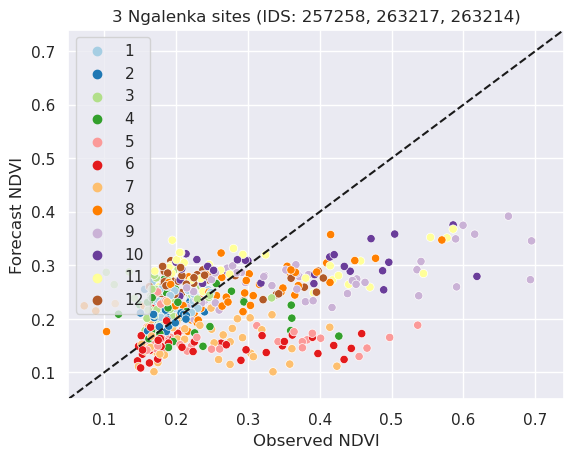

In [239]:
ax = sns.scatterplot(x='x', y='y', hue='Month of Year', data=df3, palette='Paired')
ax.set(title='3 Ngalenka sites (IDS: 257258, 263217, 263214)', xlabel='Observed NDVI', ylabel='Forecast NDVI', xlim=[0.05, 0.74], ylim=[0.05, 0.74])
plt.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c='k')
plt.legend(loc='upper left')

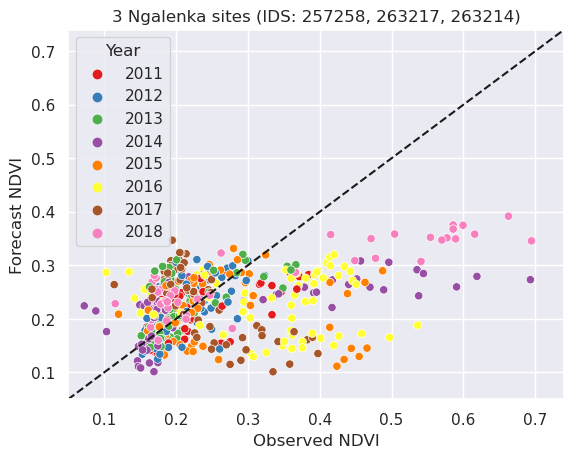

In [235]:
df3['Year'] = pd.to_datetime(df3.index.get_level_values(1), format='%Y_%m_%d').year
ax = sns.scatterplot(x='x', y='y', hue='Year', data=df3, palette='Set1')
ax.set(title='3 Ngalenka sites (IDS: 257258, 263217, 263214)', xlabel='Observed NDVI', ylabel='Forecast NDVI', xlim=[0.05, 0.74], ylim=[0.05, 0.74])
plt.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c='k')

### Frequency analysis:

In [264]:
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import blackman

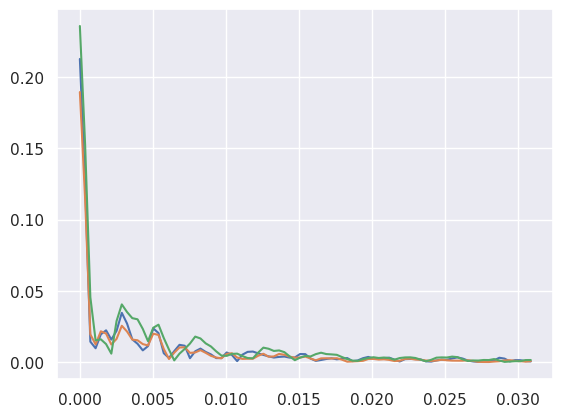

In [265]:
N = ngalenka.iloc[:, 4:-1].T.shape[0] # number of samples
w = blackman(N)
T = 16 # time sampling of 16 days
y0 = ngalenka.iloc[0, 4:-1].T
y1 = ngalenka.iloc[1, 4:-1].T
y2 = ngalenka.iloc[2, 4:-1].T
yf0 = fft(w*y0)
yf1 = fft(w*y1)
yf2 = fft(w*y2)

xf = fftfreq(N, 16)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf0[0:N//2]))
plt.plot(xf, 2.0/N * np.abs(yf1[0:N//2]))
plt.plot(xf, 2.0/N * np.abs(yf2[0:N//2]))


In [244]:
ngalenka.iloc[0, 4:-1].T

2011_04_23    0.2181
2011_05_09    0.1804
2011_05_25    0.1847
2011_06_10    0.1925
2011_06_26    0.2628
               ...  
2018_08_29    0.4152
2018_09_14    0.6156
2018_09_30    0.6625
2018_10_16    0.5856
2018_11_01    0.5856
Name: 118, Length: 174, dtype: object